# Libs & parameters

In [1]:
import numpy as np
import pandas as pd
import random
from bs4 import BeautifulSoup
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEED = 21
BATCH_SIZE = 2
EPOCHS = 15
LEARNING_RATE = 0.001

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(SEED)

In [6]:
torch.cuda.is_available()

True

# Functions

In [7]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)   
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
    
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')

    num_objs, boxes, labels = len(objects), [], []
    for i in objects:
        boxes.append(generate_box(i))
        labels.append(generate_label(i))

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    img_id = torch.tensor([image_id])        
    return {"boxes": boxes, "labels": labels, "image_id": img_id}

In [8]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'

        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
def model_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [11]:
def plot_image(img_tensor, annotation):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    plt.axis('off')
    img = img_tensor.cpu().data
    ax.imshow(img.permute(1, 2, 0))

    dict_class = {1: 'no mask', 2: 'mask', 3: 'inc mask'}
    dict_color = {1: 'r', 2: 'g', 3: 'b'}
    counter = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box
        predict = 'None'
        for i in range(1, 4):
            if int(annotation["labels"][counter]) == i:
                try:
                    predict = dict_class[i] + ':' + str(round(float(annotation["scores"][counter]), 2))
                    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                             linewidth=1, edgecolor=dict_color[i], facecolor='none')
                except:
                    predict = dict_class[i]
                    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin),
                                             linewidth=1, edgecolor=dict_color[i], facecolor='none')

        if predict != 'None':
            plt.text(xmax, ymax, f'{predict}', size=((xmax - xmin) / img.shape[2]) * 80, rotation=0.,
                     ha="right",
                     va="top",
                     bbox=dict(boxstyle="square",
                               ec=(1., 0.5, 0.5),
                               fc=(1., 0.8, 0.8)))
        ax.add_patch(rect)
        counter += 1

In [12]:
def area_boxes(boxA, boxB):
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]), float(boxB[2]))
    yB = min(float(boxA[3]), float(boxB[3]))

    interArea = abs(max(0, xB - xA) * max(0, yB - yA)) 

    boxAArea = abs((float(boxA[2]) - float(boxA[0])) * (float(boxA[3]) - float(boxA[1])))
    boxBArea = abs((float(boxB[2]) - float(boxB[0])) * (float(boxB[3]) - float(boxB[1])))  

    iou = interArea / (boxAArea + boxBArea - interArea)                                                                
    return iou

In [13]:
def clean_boxes(pred_boxes, area_boxes):
    clean_pred_boxes = {'boxes': [], 'labels': [], 'scores': []}
    final_boxes = {'boxes': [], 'labels': [], 'scores': []}
    for i in range(len(pred_boxes['boxes'])):
        if pred_boxes['scores'][i] > 0.2:
            clean_pred_boxes['boxes'].append(list(map(lambda box: int(box), pred_boxes['boxes'][i])))
            clean_pred_boxes['labels'].append(pred_boxes['labels'][i].item())
            clean_pred_boxes['scores'].append(pred_boxes['scores'][i].item())
    for i in range(len(clean_pred_boxes['boxes'])):
        max_probability = clean_pred_boxes['scores'][i]
        ind = i
        for j in range(len(clean_pred_boxes['boxes'])):
            if area_boxes(clean_pred_boxes['boxes'][i], clean_pred_boxes['boxes'][j]) > 0.3 and \
                    clean_pred_boxes['scores'][j] > max_probability:
                max_probability = clean_pred_boxes['scores'][j]
                ind = j
        if clean_pred_boxes['boxes'][ind] not in final_boxes['boxes']:
            final_boxes['boxes'].append(clean_pred_boxes['boxes'][ind])
            final_boxes['labels'].append(clean_pred_boxes['labels'][ind])
            final_boxes['scores'].append(clean_pred_boxes['scores'][ind])
    return final_boxes

In [14]:
def train_func(model, train_loader, optimizer):
    train_loss = 0

    for imgs, annotations in train_loader:
        imgs = list(img.to(DEVICE) for img in imgs)
        annotations = [{q: w.to(DEVICE) for q, w in n.items()} for n in annotations]

        loss_dict = model([imgs[0]], [annotations[0]])
        loss = sum(loss for loss in loss_dict.values())       

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(train_loader)

In [15]:
def test_func(model, test_loader):
    test_loss = 0

    with torch.no_grad():                        
        for imgs, annotations in test_loader: 
            imgs = list(img.to(DEVICE) for img in imgs)
            annotations = [{q: w.to(DEVICE) for q, w in n.items()} for n in annotations]

            loss_dict = model([imgs[0]], [annotations[0]])
            loss = sum(loss for loss in loss_dict.values())              
                 
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Data

In [16]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [17]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [18]:
dataset = MaskDataset(data_transform)

train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=generator)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

# Model

In [ ]:
model = model_detection(4)
model.to(DEVICE)

# Train Model

In [20]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(parameters, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005, nesterov=True)

In [21]:
for epoch in range(EPOCHS):    

    epoch_loss = train_func(model, train_loader, optimizer)

    torch.cuda.empty_cache()

    print(f'Epoch: {epoch+1}\nLoss: {epoch_loss}\n')

Epoch: 1
Loss: 0.41500485851256935

Epoch: 2
Loss: 0.30277029458019467

Epoch: 3
Loss: 0.2674131497602772

Epoch: 4
Loss: 0.2596791960666945

Epoch: 5
Loss: 0.23679076368334118

Epoch: 6
Loss: 0.21528140420071137

Epoch: 7
Loss: 0.19794636531790466

Epoch: 8
Loss: 0.19092922786503663

Epoch: 9
Loss: 0.17312178315111884

Epoch: 10
Loss: 0.17433921181723291

Epoch: 11
Loss: 0.16584996544284586

Epoch: 12
Loss: 0.1549027840319423

Epoch: 13
Loss: 0.14258782383468416

Epoch: 14
Loss: 0.13058564813554654

Epoch: 15
Loss: 0.13292513974470857



# Test model

In [22]:
test_loss = test_func(model, test_loader)

print(f'Test Loss: {test_loss}')

Test Loss: 0.24750693819739603


In [23]:
for imgs, annotations in test_loader: 
    imgs = list(img.to(DEVICE) for img in imgs)

In [24]:
model.eval()
predict = model(imgs)

Prediction


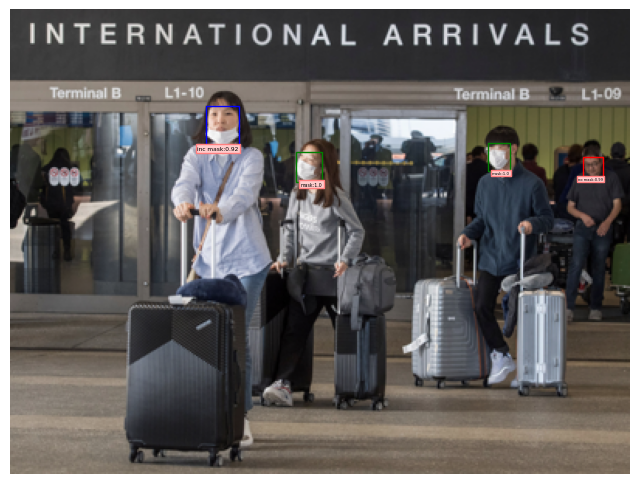

In [25]:
print("Prediction")
plot_image(imgs[0], clean_boxes(predict[0], area_boxes))

Target


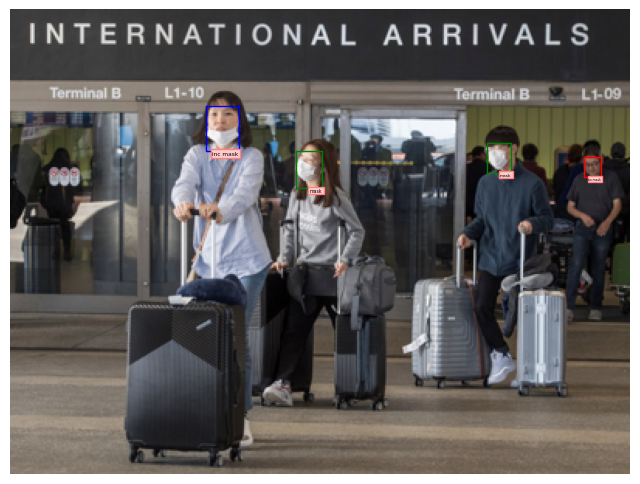

In [26]:
print("Target")
plot_image(imgs[0], annotations[0])

# Uploading your test images

In [27]:
class Test_images(object):
    def __init__(self, transforms, filename):
        self.transforms = transforms
        self.filename = filename

    def __getitem__(self, idx):
        img_path = os.path.join("/content/gdrive/MyDrive/test_images/", self.filename)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            self.img = self.transforms(img)
        return self.img

    def __len__(self):
        return len(self.img)

In [28]:
dataset_test = Test_images(data_transform,  'test_img_1.jpg')
own_img = dataset_test[0].to(DEVICE)

In [29]:
model.eval()
preds = model([own_img])

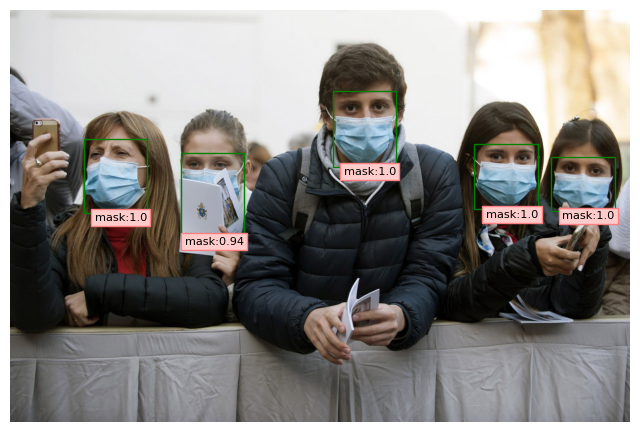

In [30]:
plot_image(own_img, clean_boxes(preds[0], area_boxes))

# Save model

In [31]:
torch.save(model.state_dict(),'model_2905.pt')